In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


In [5]:
df=pd.read_csv('../data/Cars Datasets 2025.csv',encoding='latin1')
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


let's check first of all the null values in our dataset! 

In [17]:
df.shape

(1218, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


In [8]:
df.notnull().sum()

Company Names                1218
Cars Names                   1218
Engines                      1218
CC/Battery Capacity          1215
HorsePower                   1218
Total Speed                  1218
Performance(0 - 100 )KM/H    1212
Cars Prices                  1218
Fuel Types                   1218
Seats                        1218
Torque                       1217
dtype: int64

we have some null values in Torque, performance and in CC! 

Since the missing data is less than $1\%$, we can safely use KNN Imputation or Median Imputation in our preprocessing pipeline without losing significant information.

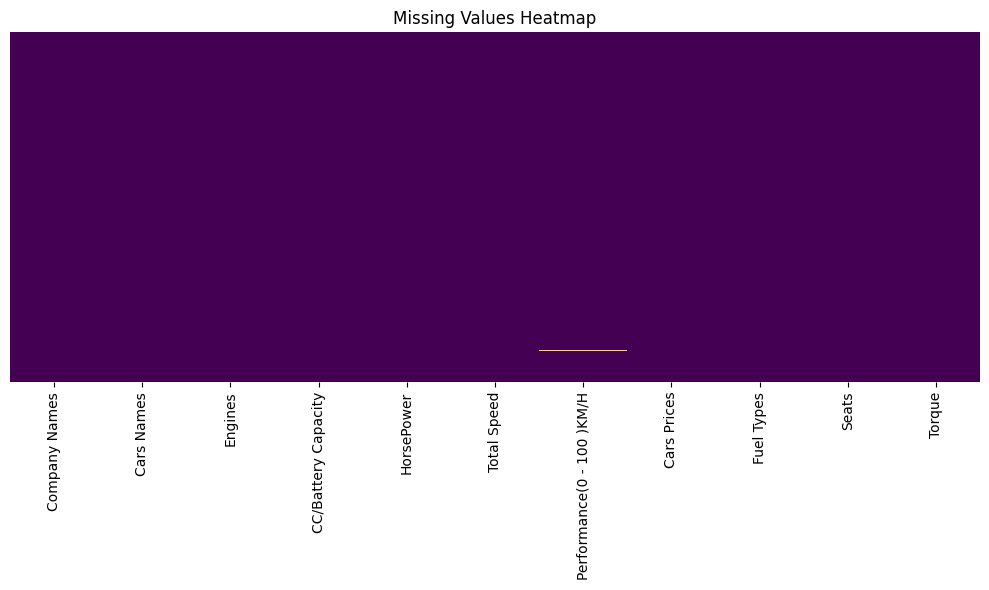

In [11]:
# 1. Null Value Analysis
null_data = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100
null_df = pd.DataFrame({'Missing Values': null_data, 'Percentage': null_percent})

# Plot Null Values Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.savefig('../data/null_heatmap.png')

C:\Users\saqib\AppData\Local\Temp\ipykernel_15592\3283241434.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette='magma')


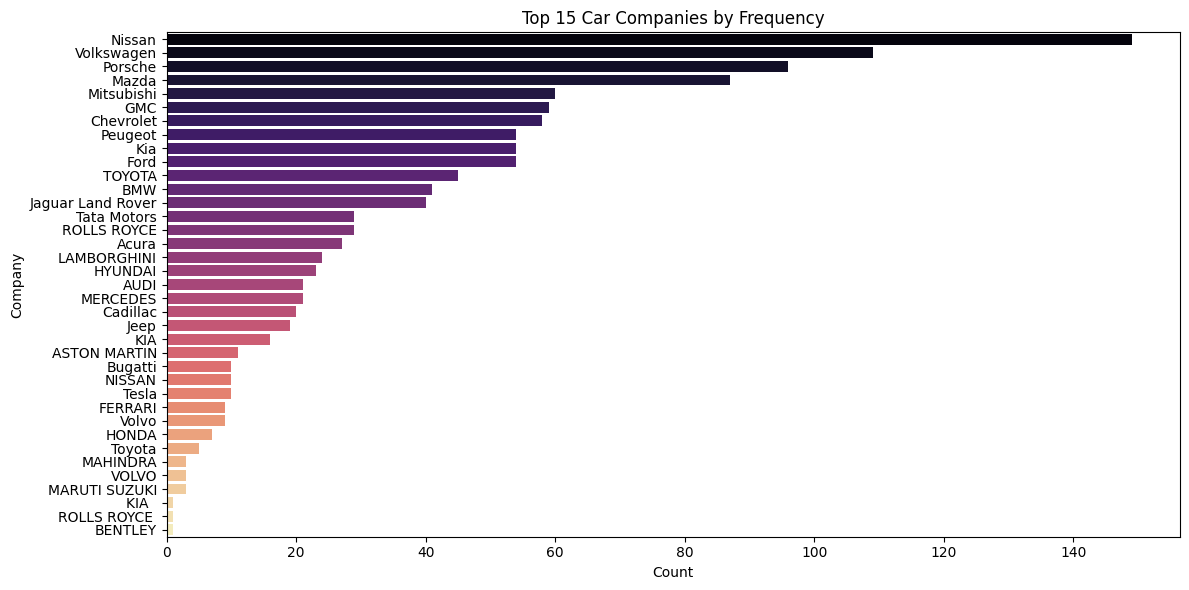

In [13]:
# 2. Categorical Analysis
# Top 15 Companies
top_companies = df['Company Names'].value_counts().head(100)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_companies.values, y=top_companies.index, palette='magma')
plt.title('Top 15 Car Companies by Frequency')
plt.xlabel('Count')
plt.ylabel('Company')
plt.tight_layout()
plt.savefig('../data/top_companies.png')

we can see the most car used by people was nissan in year 2025. 

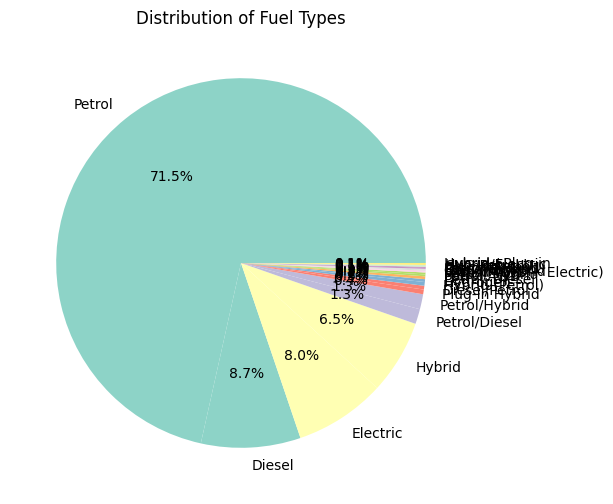

In [19]:
# Fuel Type Distribution
fuel_counts = df['Fuel Types'].value_counts()
plt.figure(figsize=(10, 6))
fuel_counts.plot(kind='pie', autopct='%1.1f%%', cmap='Set3')
plt.title('Distribution of Fuel Types')
plt.ylabel('')
# plt.tight_layout()
plt.savefig('../data/fuel_type_distribution.png')

Petrol is the dominant fuel type ($>70\%$), followed by Hybrid and Electric variants. This indicates a slight bias toward traditional combustion engines in the dataset.

In [20]:
import re

In [22]:
# 3. Numeric Data Cleaning (for Histograms & Correlation)
def clean_val(val):
    if pd.isna(val) or str(val).lower() == 'none': return np.nan
    val = str(val).lower()
    # Extract all numbers/decimals
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", val.replace(',', ''))
    if not nums: return np.nan
    # Convert to float and take average if range
    nums = [float(n) for n in nums]
    return sum(nums) / len(nums)


eda_numeric = pd.DataFrame()
eda_numeric['Price'] = df['Cars Prices'].apply(clean_val)
eda_numeric['HP'] = df['HorsePower'].apply(clean_val)
eda_numeric['CC'] = df['CC/Battery Capacity'].apply(clean_val)
eda_numeric['Speed'] = df['Total Speed'].apply(clean_val)
eda_numeric['Performance'] = df['Performance(0 - 100 )KM/H'].apply(clean_val)
eda_numeric['Seats'] = pd.to_numeric(df['Seats'], errors='coerce')

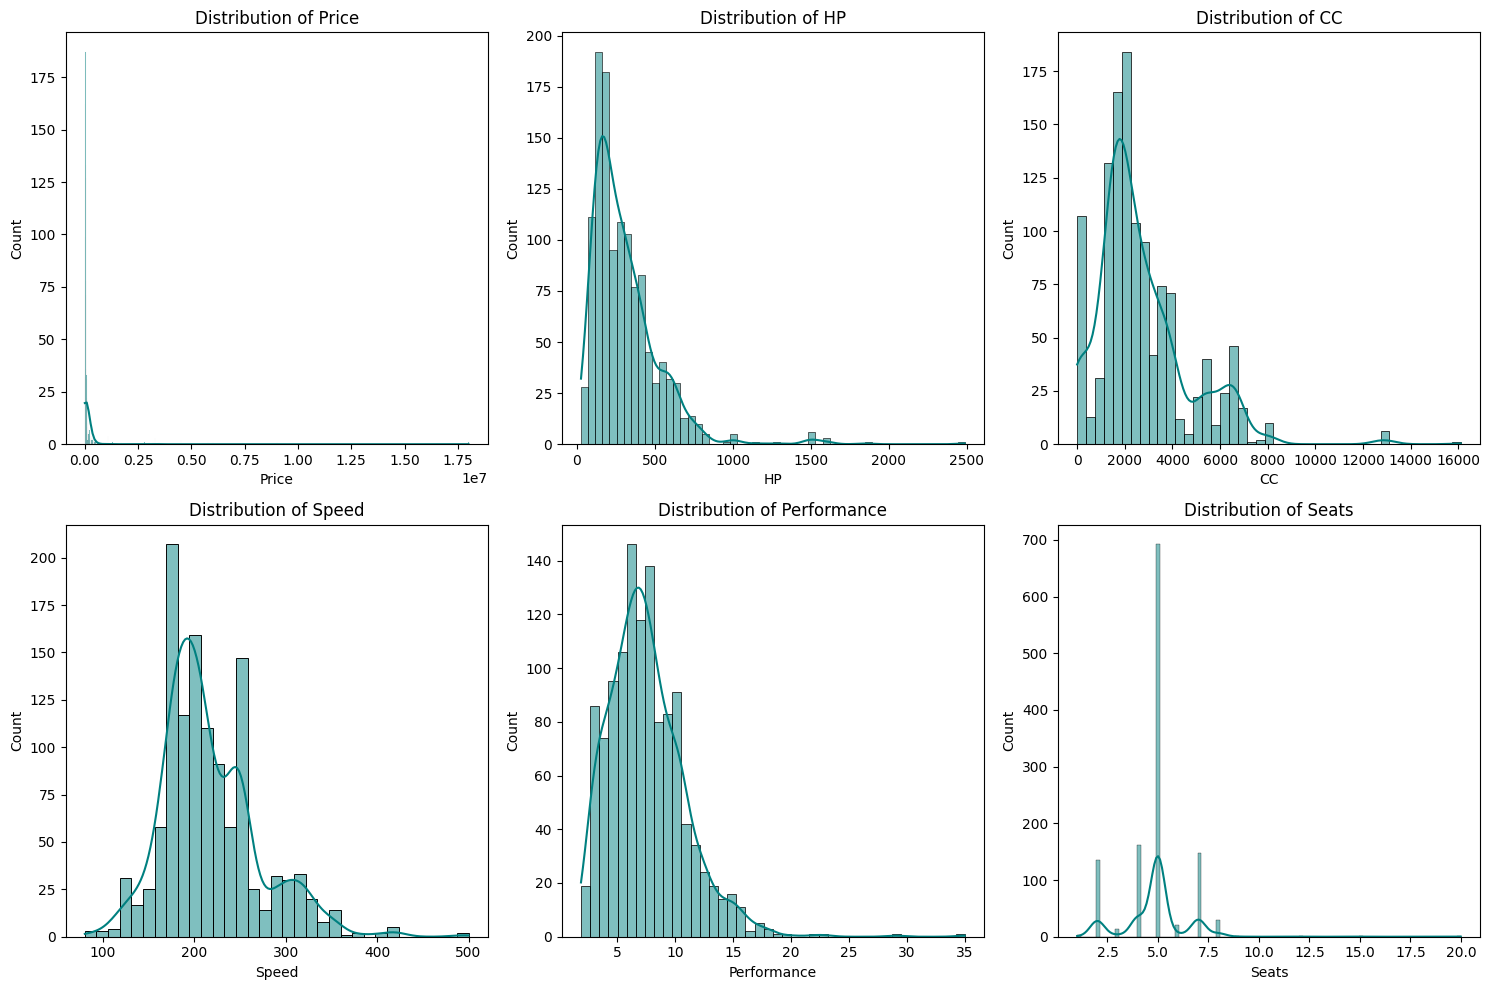

In [23]:
# 4. Histograms
plt.figure(figsize=(15, 10))
cols = eda_numeric.columns
for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(eda_numeric[col].dropna(), kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../data/numeric_distributions.png')

we can see tehe right and left skewness here and we need to deal with it 

These are extremely right-skewed. A few "Hypercars" (like the Ferrari SF90 or Bugatti) create a long tail. We will need a Log-Transformation here to help the model "see" the patterns in the more common, affordable cars.Horsepower (HP): Most cars fall in the $100-300$ hp range, with outliers reaching up to $1000+$ hp.

EDA Analysis completed. Null values summary:
                           Missing Values  Percentage
Company Names                           0    0.000000
Cars Names                              0    0.000000
Engines                                 0    0.000000
CC/Battery Capacity                     3    0.246305
HorsePower                              0    0.000000
Total Speed                             0    0.000000
Performance(0 - 100 )KM/H               6    0.492611
Cars Prices                             0    0.000000
Fuel Types                              0    0.000000
Seats                                   0    0.000000
Torque                                  1    0.082102


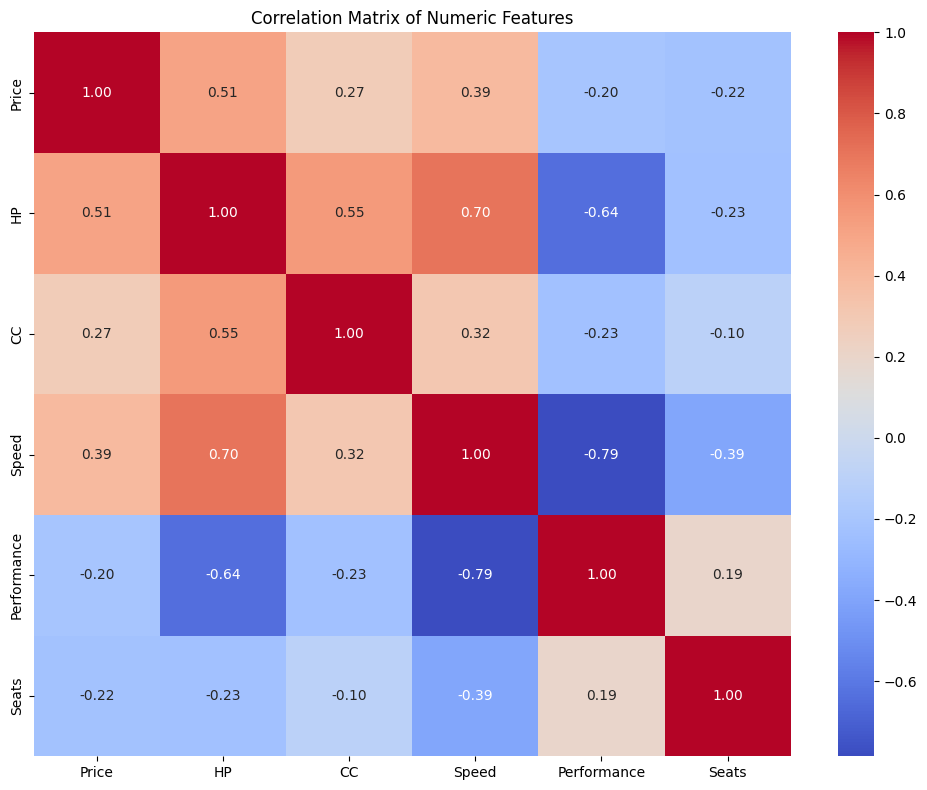

In [24]:
# 5. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(eda_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig('../data/correlation_matrix.png')

print("EDA Analysis completed. Null values summary:")
print(null_df)

1) HP and speed have a strong positive correlation of 0.75, indicating that cars with higher horsepower tend to have higher top speeds.
2) Hp and CC also show a moderate positive correlation of 0.55, suggesting that engines with larger displacements generally produce more horsepower.
3) price and Hp have a correlation of 0.51, indicating that more powerful cars tend to be more expensive.

Text(0.5, 1.0, 'HP vs. Top Speed (Corr: 0.75)')

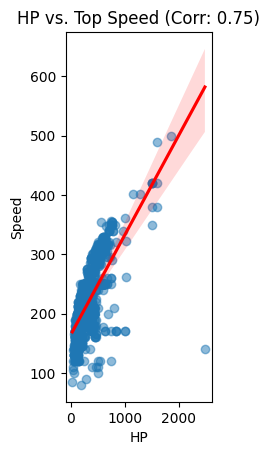

In [27]:
plt.subplot(1, 3, 1)
sns.regplot(data=eda_numeric, x='HP', y='Speed', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('HP vs. Top Speed (Corr: 0.75)')

Text(0.5, 1.0, 'CC vs. HP (Corr: 0.55)')

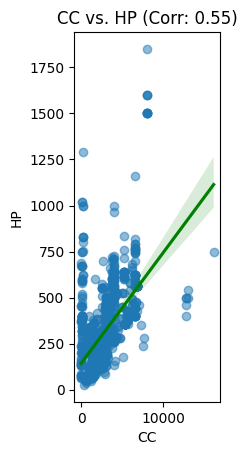

In [28]:
plt.subplot(1, 3, 2)
sns.regplot(data=eda_numeric, x='CC', y='HP', scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.title('CC vs. HP (Corr: 0.55)')

Text(0.5, 1.0, 'HP vs. Price (Corr: 0.51)')

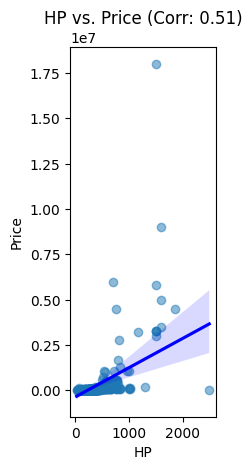

In [29]:
# Plot 3: Price vs HP
plt.subplot(1, 3, 3)
sns.regplot(data=eda_numeric, x='HP', y='Price', scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('HP vs. Price (Corr: 0.51)')

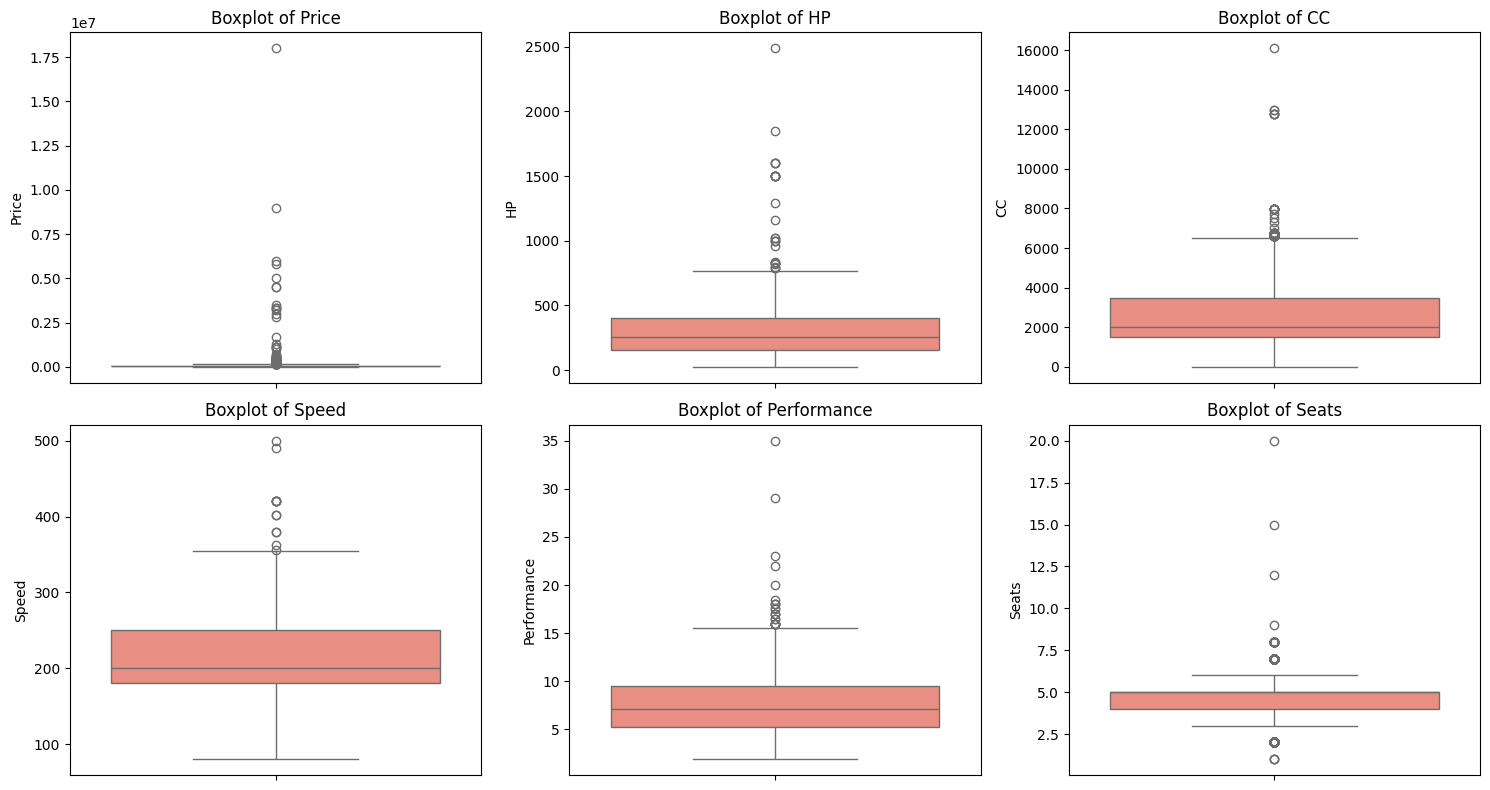

In [25]:
# 6. Boxplots for Outlier/Anomaly Detection
plt.figure(figsize=(15, 8))
for i, col in enumerate(eda_numeric.columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=eda_numeric[col], color='salmon')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('../data/outlier_boxplots.png')

The Box Plots reveal many data points beyond the whiskers, especially for Price and HP.

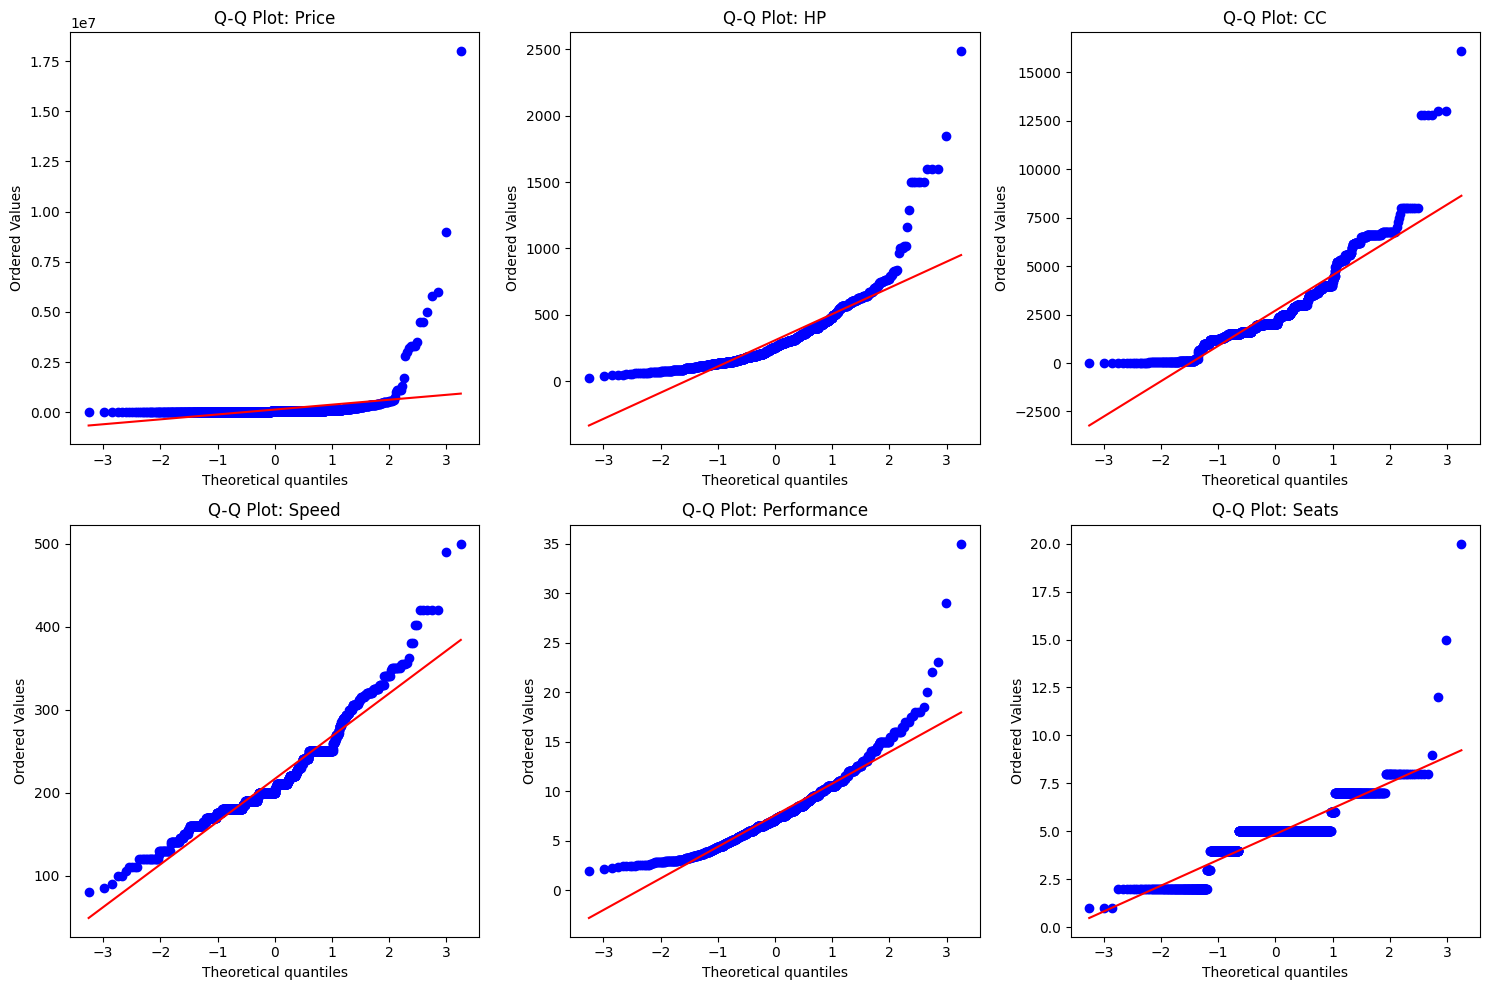

In [26]:
# 7. Q-Q Plots for Normality Check
import scipy.stats as stats

plt.figure(figsize=(15, 10))
for i, col in enumerate(eda_numeric.columns):
    plt.subplot(2, 3, i+1)
    stats.probplot(eda_numeric[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {col}')
plt.tight_layout()
plt.savefig('../data/qq_plots.png')

The Q-Q Plots show that the data does not follow a straight line, confirming that the numeric features are not normally distributed. This is a signal that we must use Scaling (StandardScaler or RobustScaler) before training.